In [1]:
!pip install xgboost scikit-learn --quiet

Loaded data shape: (17856, 170)


  0%|          | 0/170 [00:00<?, ?it/s]

Sensor 000 | MAE: 20.75 | RMSE: 28.38
Sensor 001 | MAE: 21.08 | RMSE: 29.25
Sensor 002 | MAE: 15.88 | RMSE: 20.81
Sensor 003 | MAE: 23.21 | RMSE: 32.69
Sensor 004 | MAE: 22.23 | RMSE: 30.05
Sensor 005 | MAE: 17.93 | RMSE: 24.14
Sensor 006 | MAE: 21.74 | RMSE: 29.62
Sensor 007 | MAE: 13.13 | RMSE: 17.36
Sensor 008 | MAE: 10.88 | RMSE: 14.27
Sensor 009 | MAE: 24.09 | RMSE: 33.78
Sensor 010 | MAE: 24.78 | RMSE: 41.35
Sensor 011 | MAE: 14.51 | RMSE: 19.40
Sensor 012 | MAE: 10.51 | RMSE: 17.40
Sensor 013 | MAE: 19.47 | RMSE: 26.02
Sensor 014 | MAE: 24.02 | RMSE: 31.85
Sensor 015 | MAE: 18.88 | RMSE: 25.21
Sensor 016 | MAE: 9.25 | RMSE: 12.69
Sensor 017 | MAE: 11.79 | RMSE: 23.22
Sensor 018 | MAE: 19.37 | RMSE: 25.37
Sensor 019 | MAE: 20.47 | RMSE: 27.64
Sensor 020 | MAE: 18.90 | RMSE: 25.05
Sensor 021 | MAE: 16.13 | RMSE: 21.60
Sensor 022 | MAE: 20.86 | RMSE: 27.63
Sensor 023 | MAE: 17.44 | RMSE: 23.57
Sensor 024 | MAE: 7.35 | RMSE: 9.89
Sensor 025 | MAE: 15.78 | RMSE: 22.16
Sensor 026 | MA

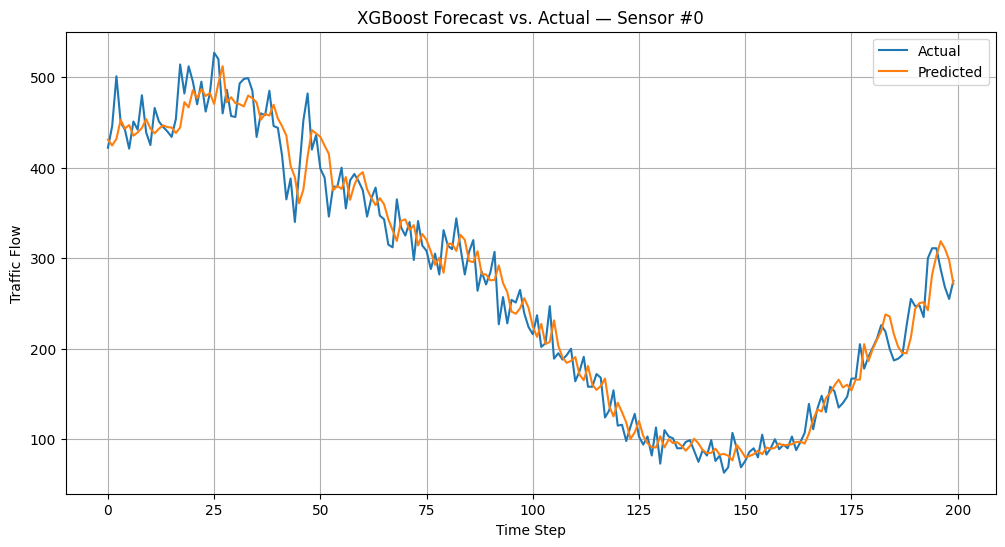

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tqdm.notebook import tqdm

# Load Data
data = np.load('/kaggle/input/traffic-forecasting/DatasetCharacteristics/pems08.npz')['data']
flow_data = data[:, :, 0]  # shape: (time, sensors)
print("Loaded data shape:", flow_data.shape)

# Parameters
SEQ_LENGTH = 12    # past 12 steps (1 hour)
PRED_STEP = 1      # predict 1 step ahead (5 mins)
TRAIN_PCT = 0.8

# Feature Generator
def create_sequences(series, seq_len, pred_step):
    X, y = [], []
    for i in range(len(series) - seq_len - pred_step + 1):
        past_vals = series[i:i+seq_len]
        target = series[i+seq_len+pred_step-1]
        X.append(past_vals)
        y.append(target)
    return np.array(X), np.array(y)

# Tracking
sensor_maes = []
sensor_rmses = []
all_preds = {}
all_tests = {}

# Loop Over All Sensors
for sensor_id in tqdm(range(flow_data.shape[1])):
    series = flow_data[:, sensor_id]
    if np.isnan(series).any():
        continue  # skip incomplete series

    X, y = create_sequences(series, SEQ_LENGTH, PRED_STEP)
    if len(X) == 0:
        continue

    split = int(len(X) * TRAIN_PCT)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    if len(X_test) == 0:
        continue

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model
    model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    # Evaluate
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if not (np.isnan(mae) or np.isnan(rmse)):
        sensor_maes.append(mae)
        sensor_rmses.append(rmse)
        all_preds[sensor_id] = preds
        all_tests[sensor_id] = y_test
        print(f"Sensor {sensor_id:03d} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# Final Report
if sensor_maes and sensor_rmses:
    print(f"\nXGBoost Average MAE across sensors: {np.mean(sensor_maes):.2f}")
    print(f"XGBoost Average RMSE across sensors: {np.mean(sensor_rmses):.2f}")
else:
    print("No valid sensors for evaluation.")

# Plot Forecast for One Sensor
if all_preds:
    sample_id = list(all_preds.keys())[0]
    print(f"\nPlotting predictions for Sensor #{sample_id}")

    plt.figure(figsize=(12, 6))
    plt.plot(all_tests[sample_id][:200], label='Actual')
    plt.plot(all_preds[sample_id][:200], label='Predicted')
    plt.title(f'XGBoost Forecast vs. Actual — Sensor #{sample_id}')
    plt.xlabel('Time Step')
    plt.ylabel('Traffic Flow')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No predictions to visualize.")